# [AI 이노베이션 스퀘어] 12기 고급 시각반
- github: https://github.com/hysKim1/AI_Vision
    - [파이썬 공식문서]https://docs.python.org/ko/3/
    - [Numpy 공식문서]https://numpy.org/devdocs/
    - [ML]https://developers.google.com/machine-learning/crash-course/ml-intro?hl=ko
    - [DL]https://www.tensorflow.org/?hl=ko
      
---
* [ RNN2](#RNN2 )
    * [ RNN in Keras](#RNN-in-Keras )
        * [SimpleRNN ](#SimpleRNN)
        * [모델 구성 ](#모델-구성)
            * [many-to-one ](#many-to-one)
            * [one-to-many ](#one-to-many)
            * [many-to-many  ](#many-to-many )
    * [Long term dependency ](#Long-term-dependency )
* [LSTM ](#LSTM)
    * [cell state ](#cell-state)
    * [gate ](#gate)


---
SimpleRNN
## RNN2

과정 요약

DNN
- 필수적 구성 요소, 사항
- 영상에 최적화된 모델 구조
  - 전처리: PIL, OpenCV

1. CNN
  - 공간적 특성
  - locally connected
    - shared weights 
  - Models: LeNet,AlexNet,JFNET, VGG, ResNet
  - 성능 최적화
    - Batch Normalization(BN): GAN에서 정리
    - Data Augmentation 
  - Transfer Learning
    - Incremental Learning
      - Catastrophic Forgetting 현상 
      - Knowledge Distillation
        - Light weights model(경량화된 모델)
          - convolution자체를 바꿈 eg. dilated convolution 
 - 활용: object detection, semantic segmentation, locallization

2. RNN : 
  - **순차적** 데이터에 최적 ( 동영상,자연어,음성에 많이 활용)
  - hidden state, state transition 학습으로 찾음 
      - 영상에서는 중요성은 떨어짐
  - ConvLSTM :RNN & CNN 구조 합침
  - CNN :공간적 특성
- 학습 전략
    - 이미지는 순서가 없지만  이미지  한열로 볼때는 순차적인 특징으로 볼 수 있음



In [ ]:
import tensorflow as tf

In [ ]:
#tf.debugging.set_log_device_placement(True) #CPU or GPU

In [ ]:
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.mnist.load_data() #hold out

11493376/11490434 [==============================] - 0s 0us/step


activation function 2가지 
- layer 내부
- 별도의 layer
  - eg. batch normalization : 레이어가 많아도 안정적으로 학습 (layer,weight,instnace, group normalization...)

In [ ]:
tf.keras.layers.Dense(64,activation='relu') #중간 삽입 불가

tf.keras.layers.Dense(64)
tf.keras.layers.BatchNormalization()
tf.keras.layers.Activation('relu')

## RNN in Keras
 - 장점 : 복잡한 모델을 인자로 유연하게 사용가능, RNN subpackages 존재
 - 단점 : 직관적이지 못함
 
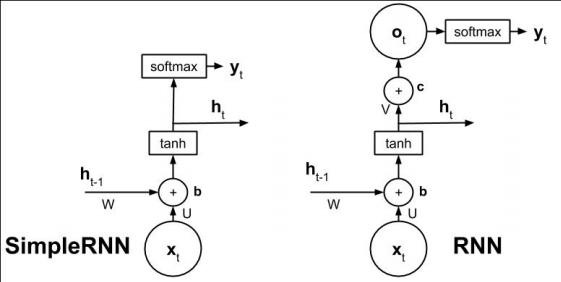
  - RNN (original) 
    - output layer wegiths 존재
    - `tf.keras.layers.RNN` cell instance 한 개
         - 복잡한 모델 구성 가능

  - simple RNN 
    - LSTM 중복되어서 생략함 
    - `tf.keras.layers.SimpleRNN(units) 
       > - NFL 지정하고 최적화

 ---

 - 이미지도 순차적 - 행이 순서대로 들어온다고 생각하고 행 별 특징 연관된 특징


##  SimpleRNN     
units : hidden layer 내의 unit(hidden state of size) 갯수
 > - CNN 인간의 뛰어넘는 성공한 모델들을 관례상 따름
 > - RNN 구조 상 학습이 잘 안되어 크기를 작게 함
 
input_shape
- 영상 해석 : 각 행 별로 순서대로 들어감  ( 28x28 : 28개 단어가 28줄 ) 

> 자연어 처리 sequence data 처리 기법:  tokenization으로 나눈 후 zero-padding으로 크기 맞춰줌 
 -  0 indexing prob, 범위, masking, bucketing 

  `(4,input_shape =(3,2))`
- 3번 2개 씩 
- 다음 레이어로 4개 넘겨줌

|||||
|--|------|---|---|
|1| I     | 0.5| 0.4|
|2| am    | 0.3| 0.1|
|3| groot | 0.7| 0.5|

> - reshape 갯수 동일
> - resize 갯수 변경 가능

In [ ]:
tf.keras.layers.SimpleRNN( units) # Dense(), Conv2D()

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN

x = tf.random.normal((31,32,3))

layer = SimpleRNN(4, input_shape=(28,32,3))
output = layer(x)

print(output.shape)

(31, 4)


### return_sequences
- 최종 sequence 만 출력할것인지 각 sequence 별로 출력할지 지정

In [36]:
layer = SimpleRNN(4, input_shape=(28,32,3), return_sequences=True)
output = layer(x)

print(output.shape)

(31, 32, 4)


### return_state
- `return_state=True` 
  - multi-outputs : 2개의 결과 output y, hidden state h  ($y_t),( h_t$)  리턴 
      - Functional paradigm:  Model: multi inputs, outputs 

In [37]:
layer = SimpleRNN(4, input_shape=(28,32,3), return_sequences=True, return_state=True )
output = layer(x)

print(output[0].shape, output[1].shape)

(31, 32, 4) (31, 4)


### TimeDistributed
data (timestpes, emb_dize) -> output(timestps, units)
- 각각의  layer를 wrapper 방식으로 감싸는 layer wrapper로 레이어를 각 sequences에 독립적으로 적용
- input 을 최소 3차원의 layer를 받음 
- `keras.layers.TimeDistributed(layer)`

동영상에서 객체 인식 
- 각 프레임에서 객체 인식
- 각 객체의 연속적인 움직임

프레임 전체를 하나의 레이어 적용하지 않고 왼쪽 같이 각각의 독립적인 레이어로 적용
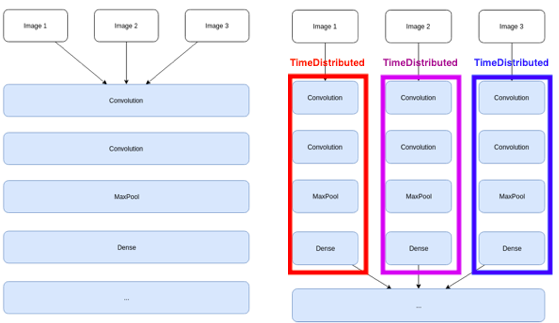
input: ( 10, 128, 128, 3) 128x128의 색상 비디오가 10 timesteps/frames
(**None**, 10, 128, 128, 3) batch size (temporal dimension), 
 각 이미지의 10 timesteps에 레이어 적용
 
 참고: https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

In [49]:
# TimeDistributed:apply a Conv2D layer to each of the 10 timesteps, independently:

inputs = tf.keras.Input(shape=(10, 128, 128, 3))
conv_2d_layer = tf.keras.layers.Conv2D(2, (3, 3))
outputs = tf.keras.layers.TimeDistributed(conv_2d_layer)(inputs)
outputs

<tf.Tensor 'time_distributed_16/Reshape_1:0' shape=(None, 10, 126, 126, 2) dtype=float32>

### Stacking Layers

In [ ]:
model=tf.keras.models.Sequential([
                                  tf.keras.layers.SimpleRNN(10,return_sequences=True
                                                            , input_shape=(28,28)),
                                  tf.keras.layers.SimpleRNN(10,return_sequences=True),
])

In [ ]:
model.summary() #이론적으로 순차적, 양방향 가능하나 연산이 느림 .. 

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_50 (SimpleRNN)    (None, 28, 10)            390       
_________________________________________________________________
simple_rnn_51 (SimpleRNN)    (None, 28, 10)            210       
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
model.add(SimpleRNN(4, input_shape=(3, 2), 
                    return_sequences=True))
model.add(Dense(1))

In [ ]:
model= tf.keras.models.Sequential([
      tf.keras.layers.SimpleRNN(10, input_shape=( 28,28 ) )    # (None, 10) 
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10)                390       
Total params: 390
Trainable params: 390
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# weights + bias + 10 = 390
 28 * 10  + 10*10 + 10 

390

In [ ]:
model(X_train) # (60000, 28,28)

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[ 0.11685292, -0.27188706, -0.26057956, ..., -0.1721199 ,
         0.00541393,  0.26554117],
       [ 0.60364145, -0.41106617,  0.00602171, ..., -0.21911363,
         0.5884861 , -0.15806794],
       [ 0.61603963, -0.62227917,  0.07432479, ..., -0.09825835,
        -0.78962183,  0.53511286],
       ...,
       [-0.15649825,  0.23550598, -0.79625523, ...,  0.37193486,
        -0.1325343 ,  0.6860386 ],
       [ 0.12433068,  0.23974733,  0.16050085, ..., -0.23386565,
         0.42140082, -0.0411865 ],
       [ 0.27056536, -0.5993022 ,  0.10297769, ...,  0.06315491,
        -0.26349387,  0.65983224]], dtype=float32)>

In [ ]:
temp=X_train[0][tf.newaxis]
model( temp )  # (1,28,28) 0번째 데이터 넣으면 결과 10개 나옴( 아직 학습 안되어서 초기값 기반)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.11685286, -0.2718871 , -0.26057953,  0.7383256 ,  0.23489252,
         0.17953256,  0.8272845 , -0.17211998,  0.00541383,  0.2655412 ]],
      dtype=float32)>

In [ ]:
import numpy as np
ss=np.resize(temp, (26,28))  #26번 28개씩 들어감 -> 0 padding으로 0채워서 길이 맞춰줌 
ss.shape

tf.keras.layers.SimpleRNN(10, input_shape=(26,28))

## 모델 구성
**활용 목적에 따라서 여러가지 입력, 결과로 다양한 모델 구성**
  - one-to-many : image captioning
  - many to one : 긍정/부정
  - many to many: trasnlation

## many-to-one
- return_sequences=False (기본값)
  - 1차식으로 들어온 것이라서 Flatten과 동일 
  
## one-to-many
- return_sequences=True
  - Flatten 따라 parameters 달라짐

In [ ]:
temp.shape  

(1, 28, 28)

In [ ]:
# return_sequences=True  
model= tf.keras.models.Sequential([
      tf.keras.layers.SimpleRNN(10, input_shape=( 28,28 ),return_sequences=True )    # one to many          
])
model(temp).shape      # 매 28개마다 각각에 대해서 10개씩 결과 

TensorShape([1, 28, 10])

In [ ]:
# return_sequences=False
model= tf.keras.models.Sequential([
      tf.keras.layers.SimpleRNN(10, input_shape=( 28,28 ),return_sequences=False )   # many to one   (Flatten 해도 상과 없음)                   
])
model(temp).shape      # 마지막에 최종적 10개 결과

TensorShape([1, 10])

In [ ]:
# return_sequences=False
model= tf.keras.models.Sequential([
      tf.keras.layers.SimpleRNN(10, input_shape=( 28,28 ),return_sequences=False , activation='tanh') ,
      #tf.keras.layers.Flatten(), #차이가 없음 
      tf.keras.layers.Dense(10,activation='softmax')                    
])
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_37 (SimpleRNN)    (None, 10)                390       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# return_sequences=True
model= tf.keras.models.Sequential([
      tf.keras.layers.SimpleRNN(10, input_shape=( 28,28 ),return_sequences=True , activation='tanh') ,
      tf.keras.layers.Dense(10,activation='softmax')                    
])
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_39 (SimpleRNN)    (None, 28, 10)            390       
_________________________________________________________________
dense_14 (Dense)             (None, 28, 10)            110       
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# return_sequences=True,  Flatten :  28x10을 1열로 바꾸어버림
model= tf.keras.models.Sequential([
      tf.keras.layers.SimpleRNN(10, input_shape=( 28,28 ),return_sequences=True , activation='relu') ,
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(10,activation='softmax')                    
])
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_41 (SimpleRNN)    (None, 28, 10)            390       
_________________________________________________________________
flatten_4 (Flatten)          (None, 280)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2810      
Total params: 3,200
Trainable params: 3,200
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#return_sequences=True 성능 좋은지 확인용 :parameters가 많으면 성능이 좋음  
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train,y_train, epochs=10) 

Epoch 1/10
1875/1875 [==============================] - 21s 11ms/step - loss: 5.9945 - acc: 0.7253
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.5310 - acc: 0.8636
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3794 - acc: 0.8919
Epoch 4/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3256 - acc: 0.9049
Epoch 5/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2920 - acc: 0.9126
Epoch 6/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2578 - acc: 0.9229
Epoch 7/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2259 - acc: 0.9321
Epoch 8/10
1875/1875 [==============================] - 22s 11ms/step - loss: 0.2127 - acc: 0.9353
Epoch 9/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2028 - acc: 0.9397
Epoch 10/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.1973 - acc: 0.9397


In [ ]:
 # return_sequences = true
model.evaluate(X_test, y_test)  #정확도 94.0%

313/313 [==============================] - 1s 4ms/step - loss: 0.1937 - acc: 0.9404


[0.19368915259838104, 0.9404000043869019]

In [ ]:
#return_sequences=False  parameters 500개로 성능이 좋지 않음
model= tf.keras.models.Sequential([
      tf.keras.layers.SimpleRNN(10, input_shape=( 28,28 ),return_sequences=False , activation='relu') ,
      tf.keras.layers.Dense(10,activation='softmax')                    
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train,y_train, epochs=10) 

Epoch 1/10
1875/1875 [==============================] - 21s 11ms/step - loss: 2.4589 - acc: 0.2476
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 1.6327 - acc: 0.4068
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 1.4585 - acc: 0.4636
Epoch 4/10
1875/1875 [==============================] - 22s 12ms/step - loss: 1.3683 - acc: 0.4897
Epoch 5/10
1875/1875 [==============================] - 21s 11ms/step - loss: 1.3117 - acc: 0.5043
Epoch 6/10
1875/1875 [==============================] - 21s 11ms/step - loss: 1.2705 - acc: 0.5182
Epoch 7/10
1875/1875 [==============================] - 20s 11ms/step - loss: 1.2362 - acc: 0.5330
Epoch 8/10
1875/1875 [==============================] - 21s 11ms/step - loss: 1.2054 - acc: 0.5444
Epoch 9/10
1875/1875 [==============================] - 22s 11ms/step - loss: 1.1806 - acc: 0.5565
Epoch 10/10
1875/1875 [==============================] - 22s 12ms/step - loss: 1.1568 - acc: 0.5724


In [ ]:
 #return_sequences=False 
model.evaluate(X_test, y_test)  #정확도 58.0%

313/313 [==============================] - 1s 3ms/step - loss: 1.1588 - acc: 0.5804


[1.158797264099121, 0.5803999900817871]

In [ ]:
# return_state=True 
inp= tf.keras.Input((28,28))
rnn=tf.keras.layers.SimpleRNN(10, return_state=True)(inp) 
model=tf.keras.models.Model(inputs=inp, outputs=rnn) #functional paradigm 

In [ ]:
model.summary()  #multi-outputs (y_t, h_t)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
simple_rnn_43 (SimpleRNN)    [(None, 10), (None, 10)]  390       
Total params: 390
Trainable params: 390
Non-trainable params: 0
_________________________________________________________________


## many-to-many
- return_sequences=True,`TimeDistributed` layer wrapper

In [ ]:
# TimeDistributed 3차원 받음 : return_sequences=True : TensorShape([1, 10])  -> TensorShape([1, 28, 10]) 
layer1= tf.keras.layers.SimpleRNN(10, input_shape=(28,28), return_sequences=True ) 

# TimeDistributed: Dense 분배
dense= tf.keras.layers.Dense(10)
layer2=tf.keras.layers.TimeDistributed(dense ) # wrapper방식으로 레이어를 감싸서 구현

In [ ]:
model= tf.keras.models.Sequential([
                                  layer1,
                                   layer2 # SimpleRNN이미 감쌌음
])

model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_34 (SimpleRNN)    (None, 28, 10)            390       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 28, 10)            110       
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#위와 비교 했을때는 차이가 없음 time distributed 표기 외에 
model= tf.keras.models.Sequential([
      tf.keras.layers.SimpleRNN(10, input_shape=( 28,28 ),return_sequences=True , activation='tanh') ,
       tf.keras.layers.Dense(10,activation='softmax')                    
])
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_45 (SimpleRNN)    (None, 28, 10)            390       
_________________________________________________________________
dense_19 (Dense)             (None, 28, 10)            110       
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(8), input_shape=(10, 16)))

In [ ]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, 10, 8)             136       
Total params: 136
Trainable params: 136
Non-trainable params: 0
_________________________________________________________________


## Long term dependency 
 - 현재 상태가 이전 상태를 기반으로 연속적 상태 지속되는데 최종결과가만 보면 성능이 안좋음
   -  논문: Learning Long-trm dependencies with gradient descent is difficult
   - 단기 기억은 잘 되나 현재 시점에서 멀어질 수록 학습이 잘 안되는 문제
  
   - Gradient Vanishing 문제 
    1. 활성 함수 sigmoid, tanh 사용대신에 `relu`
      - sigmoid, tanh : 깊을수록 미분값이 0에 가까워지면서 0이 계속 전달되면서 학습이 잘 안됨 
      - #이러한 문제로 학습이 잘 안됨 ->relu (0,max()) gradient가 사라지지 않음 , 비선형, 학습속도 빠름
      - gradient가 사라지지 않고 0을 기점으로 학습 속도가 빠름 
    2. 초기값 initalizer
      - 특정 범위에 벗어나지 않게 초기화

In [1]:
x=tf.Variable(tf.range(-8., 8, .1))
with tf.GradientTape(persistent=True) as t:
  y=tf.nn.sigmoid(x)

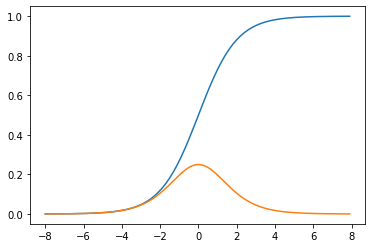

In [6]:
import matplotlib.pyplot as plt

plt.plot(x.numpy(),y.numpy()) #sigmoid
plt.plot(x.numpy(),t.gradient(y,x).numpy() )#미분한 sigmoid  끝에는 0에 가까워서 gradient vanishing

In [ ]:
tf.keras.layers.Dense(kernel_initializer=, bias_initializer=) # 기본 랜덤하게 지정

 - gradient exploding 문제
        - 학습하면서 값들이 커짐
    1. 아주 작은 초기값(naiive)
    2. gradient clipping 일정 이상 값을 잘름

In [12]:
x=tf.random.normal((4,4))

In [13]:
#gradient update 1000번 랜덤한값 곱함
for i in range(1000):
  x = tf.matmul(x, tf.random.normal((4,4)))

In [14]:
x  #너무 커서 nan(not a number)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]], dtype=float32)>

In [ ]:
dir(tf.keras.optimizers.Optimizer) #상속받는애는 2가지 옵션 

['_HAS_AGGREGATE_GRAD',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_add_variable_with_custom_getter',
 '_aggregate_gradients',
 '_assert_valid_dtypes',
 '_call_if_callable',
 '_checkpoint_dependencies',
 '_clip_gradients',
 '_compute_gradients',
 '_create_all_weights',
 '_create_hypers',
 '_create_or_restore_slot_variable',
 '_create_slots',
 '_decayed_lr',
 '_deferred_dependencies',
 '_dense_apply_args',
 '_distributed_apply',
 '_distribution_strategy_scope',
 '_fallback_apply_state',
 '_gather_saveables_for_checkpoint',
 '_get_hyper',
 '_handle_defer

### LSTM
- Long Short-Term Memory
- 영상처리의 기본 모델 LSTM, 변형: GRU

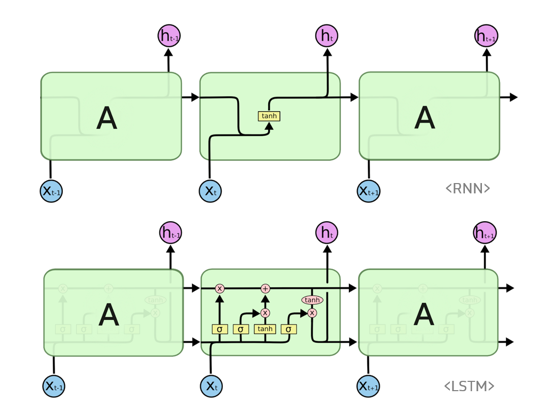
- Rnn : single tanh layer
- LSTM: 3 gates , 4 layers로 '구조 자체를 변경'해서 인간의 사고 구조를 흉내내어 현재 시점으로 부터 멀어질수록 학습이 잘 안되는 문제를 해결

> ResNet(2015):152 layers 
  -  underfitting: residual block 학습 상태 유지함
  - LSTM(1997)으로부터 얻어온 아이디어 

#### cell state
 **cell sate에 정보를 추가하고 제거하**하도록 컨베이어 벨트처럼 만듦(기억 저장)
- 그전의 셀의 내용이 현재 셀에 전달(단방향)
- 3개의 gate를 통해서 기억 조절

#### gate
1. forget gate layer: 0~1 사이의 값으로 이전 값을 잊을지 결정
- $f_t=\sigma(W_f[h_{t-1},x_t]+b_f)$
 
2. input gate layer
  - 현재 입력된 새 정보 업데이트
  - $i_t=\sigma(W_i[h_{t-1},x_t]+b_i)$
  - $ {C_t}^~ tanh(W_C[h_{t-1},x_t]+b_C)$
  - 강도 sigmoid 0 ~ 1, 방향 tanh -1 ~ 1(zero-centered)  
  - $ {C_t}^~ f_t C{t_1} + i_tC_t$
gate에서 나온 값들을 연산을 통해서 이전 cell state를 얼만큼 잊고 새로운 정보를 더하여 현재 cell state 업데이트 
3. output gate layer
- $o_t= \sigma(W_o[h_{t-1},x_t]+b_o) $
- $h_t=o_t * tanh(C_t)$
    -  cell state 기반으로 어떤 값을 output으로 내보낼지 지정


> - sigmoid : 특정 범위에서 계속 양수가 되어서 양의 방향으로만 움직여서 목적에 도달하는데 오래 걸리거나 도달하지 못함 (zigzag)
> - tanh    : 음의 방향으로 조절 가능하여 수렴속도가 빠르고 학습이 더 잘 됨
  
논문1: An Emperical Exploration of Recurrent Network Architecture(2015)

논문2:LSTM : A Serach Space Odyssey(2017)
- LSTM 변형 성능 체크: peep hole, GRU(Gated Recurrent Unit, LSTM 간단화해서 연산 효율성 높임)

LSTM 이미지에서는 CNN에 비해서  공간정보를 활용 하지 않아 성능이 좋지 않음


> 2015년 NIPS 딥러닝 동향: batch normalization , LSTM 

- [colah's blog LSTM post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [75]:
#before LSTM: object detection -> movement
from  tensorflow.keras.layers import TimeDistributed, Conv2D,GlobalAveragePooling2D,Dense, Dropout,LSTM
model = tf.keras.models.Sequential()

model.add( TimeDistributed(  Conv2D(64, (3,3), activation='relu'), 
    input_shape=(5, 224, 224, 3))) # 5 images...

model.add( TimeDistributed(  Conv2D(64, (3,3), activation='relu')))
# 차원 츅소
model.add(    TimeDistributed(  GlobalAveragePooling2D())) 

model.add(  LSTM(1024, activation='relu', return_sequences=False))

model.add(Dense(3, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_43 (TimeDis (None, 5, 222, 222, 64)   1792      
_________________________________________________________________
time_distributed_44 (TimeDis (None, 5, 220, 220, 64)   36928     
_________________________________________________________________
time_distributed_45 (TimeDis (None, 5, 64)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1024)              4460544   
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 3075      
Total params: 4,502,339
Trainable params: 4,502,339
Non-trainable params: 0
_________________________________________________________________


In [77]:
from  tensorflow.keras.layers import Flatten 
model = tf.keras.models.Sequential()

# 5 frames of shape (10, 20)
model.add(
    LSTM(1024, activation='relu',return_sequences=True, input_shape=(5, 10)))

# 5개의 seqeunce의 각각의 dense  
# process on each sequence item:
model.add(TimeDistributed(
    Dense(128, activation='relu')
))
model.add(TimeDistributed(
    Dense(64, activation='relu')
))
#Flatten 차원 츅소
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 5, 1024)           4239360   
_________________________________________________________________
time_distributed_48 (TimeDis (None, 5, 128)            131200    
_________________________________________________________________
time_distributed_49 (TimeDis (None, 5, 64)             8256      
_________________________________________________________________
flatten_4 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 963       
Total params: 4,379,779
Trainable params: 4,379,779
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.keras.layers.ConvLSTM2D #비디오 영상처리에 사용하는 기법 